So I am a huge coffee nerd, and searched for a dataset that contained coffee reviews so I could drill into it. This set is named the coffee reviews dataset and can be found here:
https://www.kaggle.com/datasets/schmoyote/coffee-reviews-dataset

In each item there is a review of a blend of coffee with 3 distinct reviews.

I'm first going to prepare my enviroment, and tee up som basic spaCy and NLTK data sources. 

In [39]:
import pandas as pd
import spacy
import nltk
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

In [9]:
#Load the spaCy model
nlp = spacy.load('en_core_web_sm')
nlp.max_length = 2000000  #Increase the maximum length limit 

In [10]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Aman\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Aman\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

Essentially the nltk is a fantastic natural langauge tool kit. We're going to use a tokenizer. A tokenizer divides a text into a list of sentences by using an unsupervised algorithm to build a model for abbreviation words, collocations, and words that start sentences. It must be trained on a large collection of plaintext in the target language before it can be used.

In addition, were going to extract the stop words. A stop word is a frequently used word (like "the," "a," "an," or "in"), and adds no relative meaning to the analysis were going to do. 

From here, were going to load in the CSV, extract the 3 reviews per coffee, and transform them into a singular dataframe, and save that. 


In [12]:
#Load the CSV file
file_path = 'coffee_analysis.csv'
df = pd.read_csv(file_path)

#Extract reviews
desc_df = df[['desc_1', 'desc_2', 'desc_3']]

#Transform the reviews from one row with three reviews to three rows with 1 review (melt it)
melted_desc_df = desc_df.melt(var_name='description_type', value_name='description').drop(columns='description_type')
melted_desc_df

,description
0,"Evaluated as espresso. Sweet-toned, deeply ric..."
1,"Evaluated as espresso. Sweetly tart, floral-to..."
2,"Crisply sweet, cocoa-toned. Lemon blossom, roa..."
3,"Delicate, sweetly spice-toned. Pink peppercorn..."
4,"Deeply sweet, subtly pungent. Honey, pear, tan..."
...,...
6280,"A quietly confident, sweetly nut-toned Guatema..."
6281,"A deeply floral, richly chocolaty Guatemala cu..."
6282,"A bright, balanced, juicy Guatemala cup driven..."
6283,"Balanced, bright, invigoratingly crisp, with t..."


Now let's make a corpus file so we ideally never have to do this again. 

In [13]:
#Clean the data
melted_desc_df = melted_desc_df.dropna()
#Turn it into a list, so that we can write it out. 
corpus = melted_desc_df['description'].tolist()

#save the corpus
corpus_file_path = 'descriptions_corpus.txt'
with open(corpus_file_path, 'w', encoding='utf-8') as file:
    for description in corpus:
        file.write(description + '\n')
        


In [14]:
total_descriptions = len(corpus)
lengths = [len(description) for description in corpus]
average_length = sum(lengths) / total_descriptions
longest_description = max(corpus, key=len)
shortest_description = min(corpus, key=len)

summary_statistics = {
    'Total Descriptions': total_descriptions,
    'Average Length': average_length,
    'Longest Description': longest_description,
    'Length of Longest Description': len(longest_description),
    'Shortest Description': shortest_description,
    'Length of Shortest Description': len(shortest_description)
}
summary_statistics

{'Total Descriptions': 6283,
 'Average Length': 297.3931243036766,
 'Longest Description': 'This exceptional coffee was selected as the No. 24 coffee on\xa0Coffee Review’s\xa0list of the Top 30 Coffees of 2018.\xa0 This coffee tied for the highest rating in a tasting of natural-processed single-origin espressos for Coffee Review’s August 2018 tasting report. With its generally elongated beans and distinctive floral and crisp, often chocolaty cup, the Gesha variety of Arabica continues to distinguish itself as one of the world’s rarest and most unique coffees. Although the Gesha originated in Ethiopia, it was “discovered” by the coffee world in 2004 growing in Boquete, Panama, and Panama continues to dominate the expanding world of Gesha. This particular version, however, is the outcome of efforts to commercialize Gesha in the region from which it originally came. It was grown in western Ethiopia by farmers Adam and Rachel Overton and their indigenous Meanit culture collaborators from s

In [31]:
all_text = " ".join(corpus[:200]) #were going to play with just 20 reviews, and then expand out to the whole set. This will help with runtime

In [32]:
#Create a single text from all descriptions for NLP processing
#all_text = " ".join(corpus)
#all_text = " ".join(corpus[:20])

#Tokenize
tokens = word_tokenize(all_text.lower())

#Remove stop words
stop_words = set(stopwords.words('english'))
filtered_tokens = [word for word in tokens if word.isalnum() and word not in stop_words]

In [33]:
#Calculate how diverse the review is
lexical_diversity = len(set(filtered_tokens)) / len(filtered_tokens)

#Calculate 200 most common words
word_freq = Counter(filtered_tokens)
most_common_words = word_freq.most_common(200)

#Use spaCy for NER
doc = nlp(all_text)
entities = [(entity.text, entity.label_) for entity in doc.ents]
entity_counter = Counter(entities)

#Get interesting stuff
summary_statistics = {
    'Total Descriptions': total_descriptions,
    'Average Length': average_length,
    'Longest Description': longest_description,
    'Length of Longest Description': len(longest_description),
    'Shortest Description': shortest_description,
    'Length of Shortest Description': len(shortest_description),
    'Lexical Diversity': lexical_diversity,
    'Most Common Words': most_common_words,
    'Named Entities': entity_counter.most_common(10) #I wanted to see if there was any fun named entities
}

summary_statistics_df = pd.DataFrame.from_dict(summary_statistics, orient='index', columns=['Value'])
summary_statistics_df

,Value
Total Descriptions,6283
Average Length,297.393
Longest Description,This exceptional coffee was selected as the No...
Length of Longest Description,1380
Shortest Description,"A plush, smooth roast-touched Kona."
Length of Shortest Description,35
Lexical Diversity,0.0943241
Most Common Words,"[(cup, 211), (finish, 201), (aroma, 199), (mou..."
Named Entities,"[((three, CARDINAL), 23), ((Baker, PERSON), 14..."


NER doesn't seem to be working too well, but its rather interesting to see that Cup, Finish and Aroma are pretty common words (at least among the 200 supercut) 

In [34]:
sorted_word_freq = word_freq.most_common()
total_words = sum(word_freq.values())
cumulative_count = 0
unique_word_count = 0
words_that_represent_half = []
for word, freq in sorted_word_freq:
    cumulative_count += freq
    unique_word_count += 1
    words_that_represent_half.append(word)
    if cumulative_count >= total_words / 2:
        break

# Display the result
unique_word_count, words_that_represent_half

(34,
 ['cup',
  'finish',
  'aroma',
  'mouthfeel',
  'structure',
  'chocolate',
  'sweet',
  'notes',
  'long',
  'sweetly',
  'zest',
  'richly',
  'short',
  'acidity',
  'dark',
  'deeply',
  'syrupy',
  'crisp',
  'tart',
  'cedar',
  'resonant',
  'baker',
  'almond',
  'balanced',
  'flowers',
  'hint',
  'rich',
  'crisply',
  'roasted',
  'juicy',
  'savory',
  'bright',
  'sandalwood',
  'cacao'])

Its interesting to see it takes 34 words to represent half of the total words in the corpus. Weirdly 'finish', 'aroma', 'cup', 'mouthfeel', 'structure', are all words very targeted towards coffee tasting, whereas the remainder are all common words to describe flavor. 

In [35]:
most_common_words

[('cup', 211),
 ('finish', 201),
 ('aroma', 199),
 ('mouthfeel', 186),
 ('structure', 170),
 ('chocolate', 169),
 ('sweet', 163),
 ('notes', 124),
 ('long', 107),
 ('sweetly', 105),
 ('zest', 98),
 ('richly', 95),
 ('short', 86),
 ('acidity', 80),
 ('dark', 71),
 ('deeply', 68),
 ('syrupy', 66),
 ('crisp', 65),
 ('tart', 63),
 ('cedar', 60),
 ('resonant', 56),
 ('baker', 56),
 ('almond', 54),
 ('balanced', 52),
 ('flowers', 52),
 ('hint', 51),
 ('rich', 47),
 ('crisply', 46),
 ('roasted', 43),
 ('juicy', 43),
 ('savory', 43),
 ('bright', 43),
 ('sandalwood', 42),
 ('cacao', 41),
 ('nib', 41),
 ('drying', 40),
 ('delicate', 40),
 ('satiny', 40),
 ('fruit', 34),
 ('dried', 33),
 ('floral', 33),
 ('black', 31),
 ('cocoa', 31),
 ('gently', 30),
 ('full', 30),
 ('lemon', 29),
 ('florals', 28),
 ('evaluated', 27),
 ('espresso', 27),
 ('milk', 27),
 ('tangerine', 27),
 ('orange', 27),
 ('velvety', 27),
 ('plush', 26),
 ('small', 26),
 ('consolidates', 26),
 ('grapefruit', 25),
 ('lively', 25)

Interestingly, the top 200 words follow much the same structure as the representational model, with  'finish', 'aroma', 'cup', 'mouthfeel', 'structure', all in the top 10. Other than that, Chocolate, sweet, and sweetly all rather make sense to see near the top as they are very commmon flavors for coffee. 

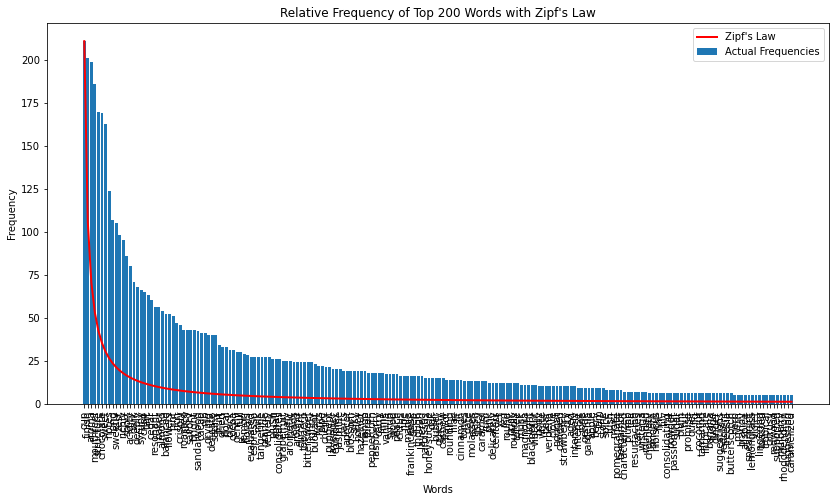

In [40]:
# Separate words and their frequencies for plotting
words, frequencies = zip(*most_common_words)

ranks = np.arange(1, len(frequencies) + 1)
zipf_frequencies = [frequencies[0] / rank for rank in ranks]

plt.figure(figsize=(14, 7))
plt.bar(words, frequencies, label='Actual Frequencies')
plt.plot(words, zipf_frequencies, color='red', label="Zipf's Law", linewidth=2)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Relative Frequency of Top 200 Words with Zipf\'s Law')
plt.xticks(rotation=90)
plt.legend()
plt.show()

Can't Zipf's law be asociated as an un-tokenized view of Benford's Law?

Zipf's law stipulates that given a large sample of words used, the frequency of any word is inversely proportional to its rank in the frequency table. In other words, the most common word will appear twice as frequently as the second most common word, etc. This law often holds true for many natural language texts, including books, articles, and spoken language, where a few words are used very frequently, and many words are used infrequently. However, I believe this principle breaks down when applied to a conformal set like tasting notes. Tasting notes often involve people using a specific subset of words to describe a similar experience through a common set of senses. Unlike general language usage, which encompasses a vast range of topics and contexts, tasting notes are constrained by the need to convey sensory experiences such as taste, aroma, and texture. This specialized vocabulary means that certain descriptive terms are used repeatedly across different tasting notes, leading to a less diverse word distribution.

Finally: In what ways do you think the frequency of the words in this corpus differ from “all words in all corpora.”
    
I believe this principle breaks down when applied to this corpus as tasting notes are trying to describe the same thing with slighlty different experiences.  This corpus, involves people using a specific subset of words to describe similar experiences through a common set of criteria or themes. Unlike a lot of other corpurses which are broder, have less specific language usage, and may encompasses a wider range of topics and contexts, this specialized context is constrained by the need to convey specific information about sensory experiences. This specialized vocabulary means that certain terms are used repeatedly across different entries, leading to a less diverse word distribution. Consequently, the frequency distribution of words in this corpus will not follow the typical pattern seen in broader, more varied language corpora, where a vast array of words are used to describe a wide range of topics.
